In [2]:
import sys
sys.path.append('/home/hwang/anaconda3/lib/python3.7/site-packages/')

from sklearn import datasets
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
import nibabel
import math
import texture

from keras.utils.np_utils import to_categorical
from keras import optimizers 
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout, Input, Lambda, Reshape, AveragePooling2D, BatchNormalization
from keras.layers.merge import add, concatenate
from keras.applications.resnet50 import ResNet50, decode_predictions

from keras import backend as K
from keras.utils import plot_model

from keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint 
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization

from keras_unet.utils import plot_imgs, get_augmented, plot_segm_history
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance 
from keras_unet.models import custom_unet

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/hwang/opt/anaconda3/lib/python3.7/site-packages/tensorflow/pyth

-----------------------------------------
keras-unet init: TF version is < 2.0.0 or not present - using `Keras` instead of `tf.keras`
-----------------------------------------


In [191]:
# delete .DS_Store file in each folder 

# resample
            
resampath =  '/Users/hwang/research/1_MM/Data/2_benign_MM/U-Net/roi_rot_test/'
# resampath = '/Users/hwang/Documents/research/2_Prostate/Unet/roi_T2/Tz_resamp/train/'

resampfile = os.listdir(resampath)
resampfile.sort()
num_seg = len(resampfile)
count_seg = 0
for item_resamp in os.listdir(resampath):
    current_resamp = os.path.basename(item_resamp)
    if current_resamp == '.DS_Store':
        fullpath = os.path.join(resampath,current_resamp)
        os.remove(fullpath)

In [3]:
# feature for deep learning (3D): img

resampath = '/Users/hwang/research/1_MM/Data/2_benign_MM/U-Net/resample_feature/train/'
# resampath = '/Users/hwang/Documents/research/2_Prostate/Unet/nT2/Tz_resamp/train/'

resampfile = os.listdir(resampath)
resampfile.sort()
num_img = len(resampfile)

first = sitk.ReadImage(os.path.join(resampath,resampfile[0]))
feature = sitk.GetArrayFromImage(first)

feature_reshape = feature.transpose(1,2,0)

num = 1

for n in os.listdir(resampath):

    i = sitk.ReadImage(os.path.join(resampath,resampfile[num]))
    j = sitk.GetArrayFromImage(i)
    j_reshape = j.transpose(1,2,0)
    feature_reshape = np.dstack((feature_reshape, j_reshape))
    
    if num < num_img-1:
        num = num + 1  

In [4]:
# feature for deep learning (3D): mask

roiresampath = '/Users/hwang/research/1_MM/Data/2_benign_MM/U-Net/resample_mask2/train/'
# roiresampath = '/Users/hwang/Documents/research/2_Prostate/Unet/roi_T2/Tz_resamp/train/'

roiresampfile = os.listdir(roiresampath)
roiresampfile.sort()
num_seg = len(roiresampfile)

first = sitk.ReadImage(os.path.join(roiresampath,roiresampfile[0]))
mask = sitk.GetArrayFromImage(first) 
mask_reshape = mask.transpose(1,2,0)

num = 1

for n in os.listdir(resampath):

    i = sitk.ReadImage(os.path.join(roiresampath,roiresampfile[num]))
    j = sitk.GetArrayFromImage(i)
    j_reshape = j.transpose(1,2,0)
    mask_reshape = np.dstack((mask_reshape, j_reshape))
    
    if num < num_seg-1:
        num = num + 1  

In [5]:
# feature normalization: 0-1

maxval = np.amax(feature_reshape)
feature_norm = feature_reshape/maxval

In [61]:
feature_norm.shape

(528, 528, 969)

In [6]:
feature = feature_norm[:,:,0:950]
feature.shape
maxval = np.amax(feature)
feature_norm = feature/maxval
feature_temp = feature_norm.transpose(2,0,1)
feature_final = feature_temp.reshape((feature_temp.shape[0],feature_temp.shape[1],feature_temp.shape[2],1))
# feature_final = feature_norm.reshape((feature_norm.shape[0],feature_norm.shape[1],feature_norm.shape[2],feature_norm.shape[3],1))
feature_final.shape
mask = mask_reshape[:,:,0:950]
mask_final = mask.transpose(2,0,1)
mask_final = mask_final.reshape((mask_final.shape[0],mask_final.shape[1],mask_final.shape[2],1))

In [7]:
X_train = feature_final
y_train = mask_final 

feature_final = feature_reshape = []
mask_final = mask_reshape = []

In [8]:
# feature for deep learning (3D): img

tresampath = '/Users/hwang/research/1_MM/Data/2_benign_MM/U-Net/resample_feature/test/'
tresampfile = os.listdir(tresampath)
tresampfile.sort()
num_img = len(tresampfile)

first = []
feature = []
feature_reshape = []

first = sitk.ReadImage(os.path.join(tresampath,tresampfile[0]))
feature = sitk.GetArrayFromImage(first)

feature_reshape = feature.transpose(1,2,0)

num = 1

for n in os.listdir(tresampath):

    i = sitk.ReadImage(os.path.join(tresampath,tresampfile[num]))
    j = sitk.GetArrayFromImage(i)
    j_reshape = j.transpose(1,2,0)
    feature_reshape = np.dstack((feature_reshape, j_reshape))
    
    if num < num_img-1:
        num = num + 1 

In [9]:
# feature for deep learning (3D): mask

mresampath = '/Users/hwang/research/1_MM/Data/2_benign_MM/U-Net/resample_mask2/test/'
mresampfile = os.listdir(mresampath)
mresampfile.sort()
num_seg = len(mresampfile)

first = []
mask = []
mask_reshape = []

first = sitk.ReadImage(os.path.join(mresampath,mresampfile[0]))
mask = sitk.GetArrayFromImage(first) 
mask_reshape = mask.transpose(1,2,0)

num = 1

for n in os.listdir(mresampath):

    i = sitk.ReadImage(os.path.join(mresampath,mresampfile[num]))
    j = sitk.GetArrayFromImage(i)
    j_reshape = j.transpose(1,2,0)
    mask_reshape = np.dstack((mask_reshape, j_reshape))
    
    if num < num_seg-1:
        num = num + 1 

In [10]:
# feature normalization: 0-1

maxval = np.amax(feature)
feature_norm = feature_reshape/maxval

In [11]:
feature = feature_norm[:,:,0:950]
feature.shape
maxval = np.amax(feature)
feature_norm = feature/maxval
feature_temp = feature_norm.transpose(2,0,1)
feature_final = feature_temp.reshape((feature_temp.shape[0],feature_temp.shape[1],feature_temp.shape[2],1))
# feature_final = feature_norm.reshape((feature_norm.shape[0],feature_norm.shape[1],feature_norm.shape[2],feature_norm.shape[3],1))
feature_final.shape
mask = mask_reshape[:,:,0:950]
mask_final = mask.transpose(2,0,1)
mask_final = mask_final.reshape((mask_final.shape[0],mask_final.shape[1],mask_final.shape[2],1))

In [12]:
X_test = feature_final
y_test = mask_final 

In [13]:
train_gen = get_augmented(X_train, y_train, batch_size = 32, data_gen_args = dict(rotation_range=5., width_shift_range = 0.05, height_shift_range = 0.05, shear_range = 40, zoom_range = 0.2, horizontal_flip = True, vertical_flip = True, fill_mode = 'constant'))
sample_batch = next(train_gen)
xx, yy = sample_batch
input_shape = X_train[0].shape

model = custom_unet(input_shape, filters = 32, use_batch_norm = True, dropout = 0.3, dropout_change_per_layer = 0.0, num_layers = 4)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 528, 528, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 528, 528, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 528, 528, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
spatial_dropout2d_1 (

In [14]:
batch_size = 32
model_filename = '2d_unet_BM.h5'
# es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1)
callback_checkpoint = ModelCheckpoint(model_filename, verbose = 1, monitor = 'val_loss', save_best_only=True)
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = [iou, iou_thresholded])

In [78]:
history = model.fit_generator(train_gen, steps_per_epoch = len(y_train)//batch_size, epochs = 100, validation_data = (X_test, y_test), callbacks = [callback_checkpoint])

Epoch 1/100
29/29 [==============================] - 2625s 91s/step - loss: 0.6747 - iou: 0.0399 - iou_thresholded: 0.0680 - val_loss: 0.4048 - val_iou: 0.0351 - val_iou_thresholded: 0.0474

Epoch 00001: val_loss improved from inf to 0.40482, saving model to 2d_unet_BM.h5
Epoch 2/100
29/29 [==============================] - 2671s 92s/step - loss: 0.5693 - iou: 0.0399 - iou_thresholded: 0.1037 - val_loss: 0.6449 - val_iou: 0.0272 - val_iou_thresholded: 0.0267

Epoch 00002: val_loss did not improve from 0.40482
Epoch 3/100
29/29 [==============================] - 2631s 91s/step - loss: 0.4764 - iou: 0.0421 - iou_thresholded: 0.1227 - val_loss: 2.1456 - val_iou: 0.0403 - val_iou_thresholded: 0.0408

Epoch 00003: val_loss did not improve from 0.40482
Epoch 4/100
29/29 [==============================] - 2620s 90s/step - loss: 0.3771 - iou: 0.0505 - iou_thresholded: 0.1879 - val_loss: 0.8081 - val_iou: 0.0567 - val_iou_thresholded: 0.0708

Epoch 00004: val_loss did not improve from 0.40482
E


Epoch 00032: val_loss did not improve from 0.03487
Epoch 33/100
29/29 [==============================] - 2617s 90s/step - loss: 0.0332 - iou: 0.5771 - iou_thresholded: 0.7099 - val_loss: 0.0409 - val_iou: 0.5622 - val_iou_thresholded: 0.6714

Epoch 00033: val_loss did not improve from 0.03487
Epoch 34/100
29/29 [==============================] - 2623s 90s/step - loss: 0.0340 - iou: 0.5636 - iou_thresholded: 0.7052 - val_loss: 0.0345 - val_iou: 0.6543 - val_iou_thresholded: 0.7299

Epoch 00034: val_loss improved from 0.03487 to 0.03447, saving model to 2d_unet_BM.h5
Epoch 35/100
29/29 [==============================] - 2620s 90s/step - loss: 0.0323 - iou: 0.5831 - iou_thresholded: 0.7113 - val_loss: 0.0339 - val_iou: 0.6406 - val_iou_thresholded: 0.7275

Epoch 00035: val_loss improved from 0.03447 to 0.03389, saving model to 2d_unet_BM.h5
Epoch 36/100
29/29 [==============================] - 2630s 91s/step - loss: 0.0315 - iou: 0.5836 - iou_thresholded: 0.7109 - val_loss: 0.0393 - val_


Epoch 00096: val_loss did not improve from 0.02226
Epoch 97/100
29/29 [==============================] - 2643s 91s/step - loss: 0.0223 - iou: 0.6867 - iou_thresholded: 0.7708 - val_loss: 0.0255 - val_iou: 0.7100 - val_iou_thresholded: 0.7754

Epoch 00097: val_loss did not improve from 0.02226
Epoch 98/100
29/29 [==============================] - 2659s 92s/step - loss: 0.0226 - iou: 0.6844 - iou_thresholded: 0.7714 - val_loss: 0.0257 - val_iou: 0.7025 - val_iou_thresholded: 0.7709

Epoch 00098: val_loss did not improve from 0.02226
Epoch 99/100
29/29 [==============================] - 2712s 94s/step - loss: 0.0216 - iou: 0.7120 - iou_thresholded: 0.7881 - val_loss: 0.0282 - val_iou: 0.7054 - val_iou_thresholded: 0.7606

Epoch 00099: val_loss did not improve from 0.02226
Epoch 100/100
29/29 [==============================] - 2615s 90s/step - loss: 0.0221 - iou: 0.6891 - iou_thresholded: 0.7776 - val_loss: 0.0236 - val_iou: 0.7212 - val_iou_thresholded: 0.7742

Epoch 00100: val_loss did 

In [20]:
model.save_weights(model_filename)
model.load_weights(model_filename)
y_pred = model.predict(X_test)

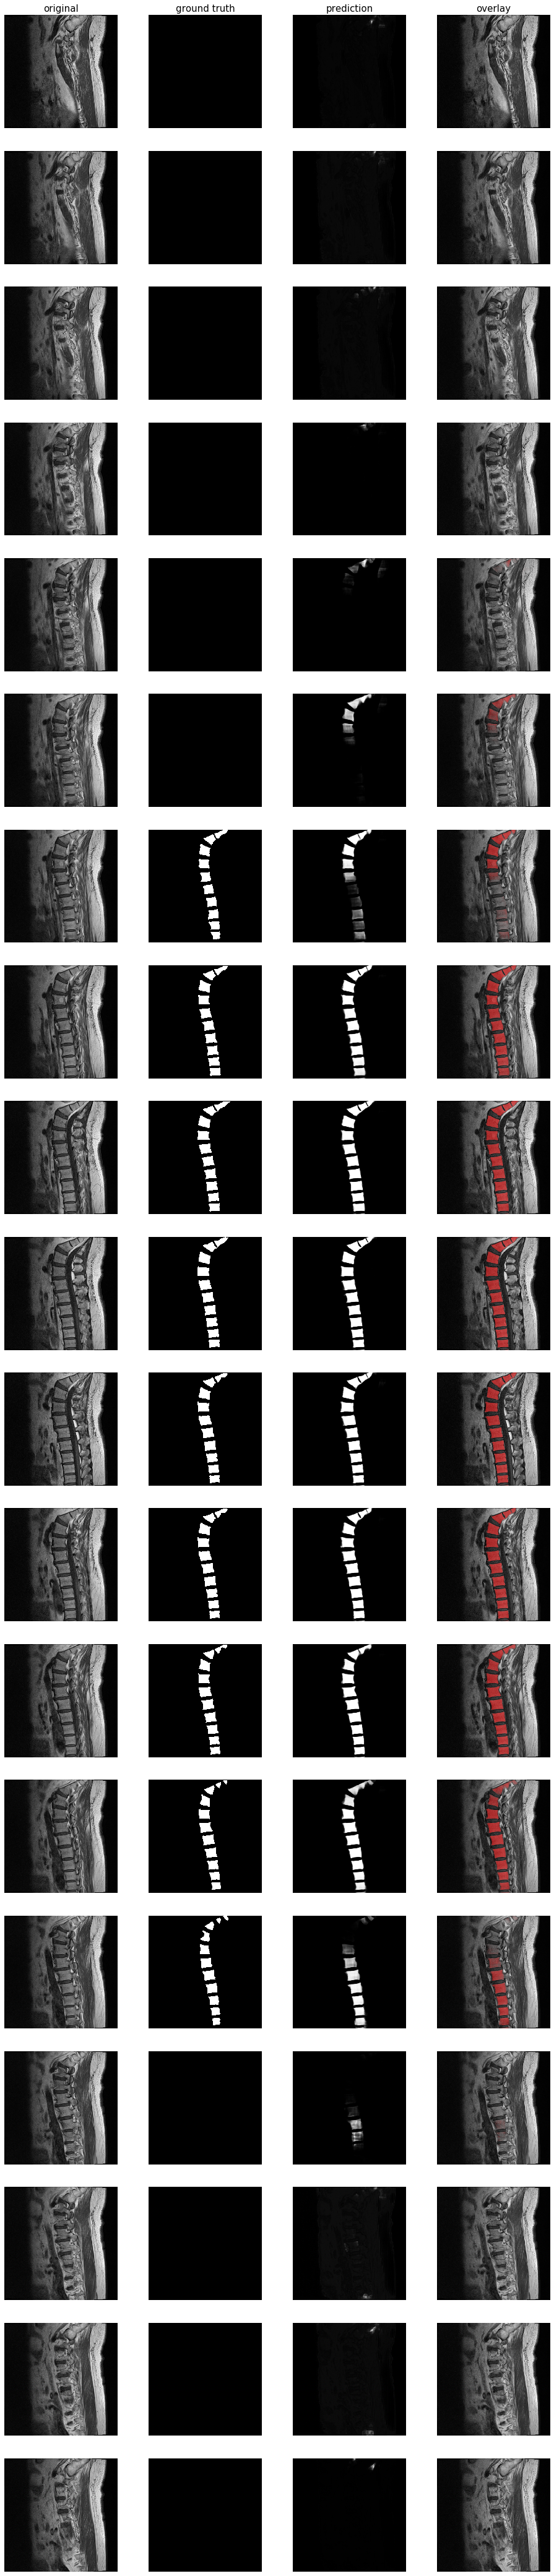

In [80]:
plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=19)

In [81]:
def dice_coef2(y_test, y_pred):
    y_test_f = y_test.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_test_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_test_f * y_pred_f)
    return 2. * intersection / union

In [82]:
dice_coef2(y_test, y_pred)

0.838658492939386

In [83]:
image = y_pred
# image = image[:,:,:, 1]
image2 = image.reshape(image.shape[0],image.shape[1],image.shape[2])

In [84]:
# save U-Net segmented BM 

predpath = '/Users/hwang/research/1_MM/Data/2_benign_MM/U-Net/pred/'

mresampath = '/Users/hwang/research/1_MM/Data/2_benign_MM/U-Net/resample_mask2/test/'
mresampfile = os.listdir(mresampath)
mresampfile.sort()
num_img = len(mresampfile)

num = 0

for n in os.listdir(mresampath):

    numslice = 19
    fslice = num*numslice
    lslice = ((num+1)*numslice)-1
    image3 = image2[fslice:lslice,:,:]
    image4 = sitk.GetImageFromArray(image3)
    image4.SetSpacing([0.5303, 0.5303, 3])
    sitk.WriteImage(image4,os.path.join(predpath,mresampfile[num]),True)
    
    if num < num_img-1:
        num = num + 1

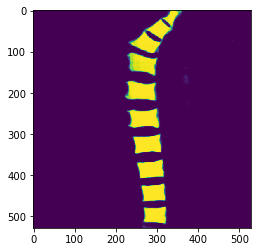

In [124]:
image5 = image2.reshape(50,19,image2.shape[1],image2.shape[2])
image5.shape
im = plt.imshow(image5[1,10,:,:])
y_pred_ind = image5 

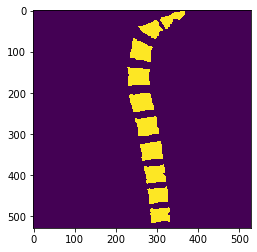

In [155]:
y_test.shape
image6 = y_test.reshape(y_test.shape[0],y_test.shape[1],y_test.shape[2])
image7 = image6.reshape(50,19,image6.shape[1],image6.shape[2])
im = plt.imshow(image7[0,10,:,:])
y_test_ind = image7

In [117]:
mresampfile = os.listdir(mresampath)
mresampfile.sort()
num_img = len(mresampfile)

num = 0

for n in os.listdir(mresampath):
    
    ind_test = y_test_ind[num,:,:,:]
    ind_pred = y_pred_ind[num,:,:,:]
    dsc = dice_coef2(ind_test, ind_pred)
    iou = dsc/(2-dsc)
    print(dsc,iou)
    
    if num < num_img-1:
        num = num + 1

0.8594966714026488 0.7536117167318586
0.8894685657618803 0.8009395667148318
0.8700026943574922 0.7699157245891091
0.8786729801848522 0.7836010054673458
0.8922600692049114 0.8054779325003524
0.8712496955204018 0.7718710613523023
0.7694993211111096 0.6253546497885294
0.8930202088779066 0.8067177161135831
0.8693950958410144 0.7689645539683243
0.8625285128595415 0.7582858318742488
0.8718365623041785 0.7727927826528671
0.7565565568470297 0.6084366450384321
0.8539885409174529 0.7451832476449436
0.8850456693063609 0.7937954451961752
0.8509251914423327 0.7405307166296896
0.8678268228147905 0.7665142049844066
0.8565864199900697 0.7491483702534217
0.8339780315149031 0.7152335496718065
0.8391365795915439 0.7228555615063563
0.7901761908281448 0.6531332784474078
0.8366893519706082 0.7192312331946168
0.8592842618088613 0.7532851814348155
0.828753143930147 0.7075819581800613
0.8652291480023179 0.7624703670165165
0.8527948458618471 0.7433673417397746
0.8729486603416161 0.7745420546735805
0.82516718600

In [128]:
mresampfile = os.listdir(mresampath)
mresampfile.sort()
num_img = len(mresampfile)

num = 0

for n in os.listdir(mresampath):
    
    ind_test = y_test_ind[num,10,:,:]
    ind_pred = y_pred_ind[num,10,:,:]
    dsc = dice_coef2(ind_test, ind_pred)
    iou = dsc/(2-dsc)
    print(dsc,iou)
    
    if num < num_img-1:
        num = num + 1

0.9235273806839304 0.8579199917511027
0.9493943469346711 0.9036638477668991
0.9411422385026664 0.8888278225130019
0.9344314304500746 0.8769322380114493
0.9453378167217392 0.8963418160906244
0.9540804439859639 0.9121929487789022
0.7313450547413336 0.5764727891335492
0.9479073624259161 0.9009732874964336
0.9321569858463701 0.8729344795922046
0.9361762367647487 0.8800106456709458
0.9364096438177011 0.8804232178062369
0.9102035237465704 0.8352050530349713
0.9281470375071778 0.8659275758762418
0.94216101766495 0.8906469069472605
0.9326167663305551 0.873741255167003
0.9515507960766529 0.9075793014252902
0.9305938595844397 0.8701968545110658
0.9441749649445488 0.8942532461308434
0.9384473650738379 0.884032815894346
0.9326116674634554 0.873732304387471
0.9362465018999728 0.8801348278263762
0.9403546535886956 0.8874239449768644
0.9162256722858311 0.845402634899351
0.9547667795927282 0.9134485595671235
0.9501416108085419 0.9050188297683534
0.9531291629712095 0.9104553582525645
0.9057035073076449

In [198]:
growcutpath = '/Users/hwang/research/1_MM/Data/2_benign_MM/U-Net/roi_rot_test/'
mansegpath = '/Users/hwang/research/1_MM/Data/2_benign_MM/U-Net/mask2_test/'

growcutfile = os.listdir(growcutpath)
growcutfile.sort()
mansegfile = os.listdir(mansegpath)
mansegfile.sort()

num = 0

for n in os.listdir(growcutpath):
    
    i = sitk.ReadImage(os.path.join(growcutpath,growcutfile[num]))
    ind_pred = sitk.GetArrayFromImage(i) 
    j = sitk.ReadImage(os.path.join(mansegpath,mansegfile[num]))
    ind_test = sitk.GetArrayFromImage(j)
    dsc = dice_coef2(ind_test, ind_pred)
    iou = dsc/(2-dsc)
    print(num,dsc,iou)
    
    if num < num_img-1:
        num = num + 1

0 0.906178184612254 0.8284513728509111
1 0.9329192518465032 0.8742724048398868
2 0.9203465054000025 0.8524461875992753
3 0.9367390454430762 0.8810057788997141
4 0.9414786033638493 0.8894280326838465
5 0.9465179902089975 0.8984662114892448
6 0.8621316674675636 0.7576726083489871
7 0.9415849064928332 0.8896177995466743
8 0.9414196779795164 0.8893228585457305
9 0.9206166223127016 0.8529097643556708
10 0.8985882901262076 0.8158514042212011
11 0.8901599907883149 0.8020615434657036
12 0.9095396839444986 0.8340878347912346
13 0.9234433308154545 0.8577749386058152
14 0.9132432176954344 0.8403381810590773
15 0.9467161195539606 0.8988233249644436
16 0.9264480674116139 0.862974616586924
17 0.9488970401275307 0.9027631700729496
18 0.9284290873078177 0.8664187094956326
19 0.88702321357654 0.7969826724122258
20 0.9407272431842713 0.8880878292501204
21 0.9390809048552906 0.8851578873007276
22 0.9222541777591201 0.8557251243540362
23 0.8511308787745822 0.7408423318634769
24 0.9276675065269686 0.865093

In [199]:
growcutpath = '/Users/hwang/research/1_MM/Data/2_benign_MM/U-Net/roi_rot_test/'
mansegpath = '/Users/hwang/research/1_MM/Data/2_benign_MM/U-Net/mask2_test/'

growcutfile = os.listdir(growcutpath)
growcutfile.sort()
mansegfile = os.listdir(mansegpath)
mansegfile.sort()

num = 0

for n in os.listdir(growcutpath):
    
    i = sitk.ReadImage(os.path.join(growcutpath,growcutfile[num]))
    ind_pred = sitk.GetArrayFromImage(i) 
    ind_pred_slice = ind_pred[10,:,:]
    j = sitk.ReadImage(os.path.join(mansegpath,mansegfile[num]))
    ind_test = sitk.GetArrayFromImage(j)
    ind_test_slice = ind_test[10,:,:]
    dsc = dice_coef2(ind_test_slice, ind_pred_slice)
    iou = dsc/(2-dsc)
    print(num,dsc,iou)
    
    if num < num_img-1:
        num = num + 1

0 0.9473450344367919 0.8999577880962433
1 0.9531042105909565 0.9104098232441732
2 0.9520243913374883 0.9084413639669706
3 0.9577610143253803 0.9189456808751415
4 0.977017869631273 0.955068363979255
5 0.9612185463764169 0.9253327954820493
6 0.8341715193223928 0.7155182200022703
7 0.9808056756888089 0.9623343186802709
8 0.9759346355865289 0.9530003352329869
9 0.9737634720760605 0.9488684582743987
10 0.9432505281561885 0.8925961671032675
11 0.9294402568777381 0.8681815871079254
12 0.9491414457042526 0.9032057091073856
13 0.9615015893839245 0.9258575454280439
14 0.9603097773475314 0.9236499068901302
15 0.966852886405959 0.9358327325162221
16 0.972071189760562 0.9456600302253763
17 0.9695800858915222 0.9409562767722766
18 0.9936484769858644 0.9873771284310039
19 0.9181088700932553 0.848614841839394
20 0.9772552199472937 0.955522080393245
21 0.9742693204231666 0.9498295603531162
22 0.9635253976644721 0.9296179525222553
23 0.9203765757140577 0.8524977830328111
24 0.9530022769718832 0.91022382

In [189]:
# resample mask (3d growcut segmentation)

resampath = '/Users/hwang/research/1_MM/Data/2_benign_MM/U-Net/resample_roi_rot_test/'
roisampath = '/Users/hwang/research/1_MM/Data/2_benign_MM/U-Net/roi_rot_test/'
refpath = '/Users/hwang/research/1_MM/Data/2_benign_MM/U-Net/resample_mask2/test/'

resampfile = os.listdir(resampath)
resampfile.sort()
roifile = os.listdir(roisampath)
roifile.sort()
reffile = os.listdir(refpath)
reffile.sort()

i = sitk.ReadImage(os.path.join(refpath,reffile[0]))
sitk.WriteImage(i, os.path.join(resampath,roifile[0]))
num_img = len(roifile)

num = 1

for item_seg in os.listdir(roisampath):

    i = sitk.ReadImage(os.path.join(refpath,reffile[num]))
    j = sitk.ReadImage(os.path.join(roisampath,roifile[num]))
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(i)
    resampled = resampler.Execute(j)
    resampfile = os.path.basename(roifile[num])
    
    sitk.WriteImage(resampled, os.path.join(resampath,resampfile))
    
    if num < num_img-1:
        num = num + 1

In [157]:
roiresampfile

['ffHC036_31308216_roi_rot.nii.gz',
 'ffHC038_31340331_roi_rot.nii.gz',
 'ffHC043_21251541_roi_rot.nii.gz',
 'ffHC046_31225712_roi_rot.nii.gz',
 'ffHC048_3545809_roi_rot.nii.gz',
 'ffHC054_24479080_roi_rot.nii.gz',
 'ffHC059_29410354_roi_rot.nii.gz',
 'ffHC065_15699414_roi_rot.nii.gz',
 'ffHC069_31332162_roi_rot.nii.gz',
 'ffHC072_24991734_roi_rot.nii.gz',
 'ffHC078_27290204_roi_rot.nii.gz',
 'ffHC084_12320165_roi_rot.nii.gz',
 'ffHC086_9218114_roi_rot.nii.gz',
 'ffHC089_24775945_roi_rot.nii.gz',
 'ffHC095_30029725_roi_rot.nii.gz',
 'ffHC114_6461936_roi_rot.nii.gz',
 'ffHC117_31157855_roi_rot.nii.gz',
 'ffHC120_31285834_roi_rot.nii.gz',
 'ffHC122_31256993_roi_rot.nii.gz',
 'ffHC125_17759905_roi_rot.nii.gz',
 'ffHC137_30738503_roi_rot.nii.gz',
 'ffHC149_24190401_roi_rot.nii.gz',
 'ffM2_20820696_roi_rot.nii.gz',
 'ffM2_24193893_roi_rot.nii.gz',
 'ffM2_29412404_roi_rot.nii.gz',
 'ffM2_7330714_2013_roi_rot.nii.gz',
 'ffM2_9761103_roi_rot.nii.gz',
 'ffM3_11718315_roi_rot.nii.gz',
 'ffM3_173

In [146]:
# 3d growcut segmentation

roi_reshape.shape
roi_final = roi_reshape[:,:,0:950]
roi_final = roi_final.transpose(2,0,1)
roi_final = roi_final.reshape((mask_final.shape[0],mask_final.shape[1],mask_final.shape[2],1))
roi_final_ind = roi_final.reshape(50,19,roi_final.shape[1],roi_final.shape[2])
roi_final_ind.shape

(50, 19, 528, 528)

In [158]:
# feature for deep learning (3D): mask

mresampath = '/Users/hwang/research/1_MM/Data/2_benign_MM/U-Net/resample_mask2/test/'
mresampfile = os.listdir(mresampath)
mresampfile.sort()
num_seg = len(mresampfile)

first = []
mask = []
mask_reshape = []

first = sitk.ReadImage(os.path.join(mresampath,mresampfile[0]))
mask = sitk.GetArrayFromImage(first) 
mask_reshape = mask.transpose(1,2,0)

num = 1

for n in os.listdir(mresampath):

    i = sitk.ReadImage(os.path.join(mresampath,mresampfile[num]))
    j = sitk.GetArrayFromImage(i)
    j_reshape = j.transpose(1,2,0)
    mask_reshape = np.dstack((mask_reshape, j_reshape))
    
    if num < num_seg-1:
        num = num + 1 

In [159]:
mresampfile

['ffHC036_31308216_roi_rot_1.nii.gz',
 'ffHC038_31340331_roi_rot.nii_1.nii.gz',
 'ffHC043_21251541_roi_rot_1.nii.gz',
 'ffHC046_31225712_roi_rot_1.nii.gz',
 'ffHC048_3545809_roi_rot_1.nii.gz',
 'ffHC054_24479080_roi_rot_1.nii.gz',
 'ffHC059_29410354_roi_rot_1.nii.gz',
 'ffHC065_15699414_roi_rot_1.nii.gz',
 'ffHC069_31332162_roi_rot_1.nii.gz',
 'ffHC072_24991734_roi_rot_1.nii.gz',
 'ffHC078_27290204_roi_rot.nii_1.nii.gz',
 'ffHC084_12320165_roi_rot_1.nii.gz',
 'ffHC086_9218114_roi_rot_1.nii.gz',
 'ffHC089_24775945_roi_rot_1.nii.gz',
 'ffHC095_30029725_roi_rot_1.nii.gz',
 'ffHC114_6461936_roi_rot_1.nii.gz',
 'ffHC117_31157855_roi_rot_1.nii.gz',
 'ffHC120_31285834_roi_rot_1.nii.gz',
 'ffHC122_31256993_roi_rot_1.nii.gz',
 'ffHC125_17759905_roi_rot_1.nii.gz',
 'ffHC137_30738503_roi_rot_1.nii.gz',
 'ffHC149_24190401_roi_rot_1.nii.gz',
 'ffM2_20820696_roi_rot_1.nii.gz',
 'ffM2_24193893_roi_rot_1.nii.gz',
 'ffM2_29412404_roi_rot_1.nii.gz',
 'ffM2_7330714_2013_roi_rot_1.nii.gz',
 'ffM2_9761103_

In [160]:
mask = mask_reshape[:,:,0:950]
mask_final = mask.transpose(2,0,1)
mask_final = mask_final.reshape((mask_final.shape[0],mask_final.shape[1],mask_final.shape[2],1))
mask_final_ind = mask_final.reshape(50,19,roi_final.shape[1],roi_final.shape[2])
mask_final_ind.shape

(50, 19, 528, 528)

In [185]:
mresampfile = os.listdir(mresampath)
mresampfile.sort()
num_img = len(mresampfile)

num = 0

for n in os.listdir(mresampath):
    
    ind_test = mask_final_ind[num,:,:,:]
    ind_pred = roi_final_ind[num,:,:,:]
    dsc = dice_coef2(ind_test, ind_pred)
    iou = dsc/(2-dsc)
    print(num,dsc,iou)
    
    if num < num_img-1:
        num = num + 1

0 0.807752664075889 0.6775042725927333
1 0.9329192518465032 0.8742724048398868
2 0.9203465054000025 0.8524461875992753
3 0.059406918346194694 0.030612764163606695
4 0.9414786033638493 0.8894280326838465
5 0.7169060134049074 0.5587322681694886
6 0.059393493535035494 0.030605634546298364
7 0.9415849064928332 0.8896177995466743
8 0.30283373023551374 0.17843492156931542
9 0.42722389767368246 0.27163681915167004
10 0.19690128079894018 0.10920160870958065
11 0.5759532042586332 0.40444822879488923
12 0.18544317568755794 0.10219750255428052
13 0.9229360820746564 0.8569000100313726
14 0.04011077092088275 0.020465835683851064
15 0.7093946711684567 0.5496604231525304
16 0.17130209414616832 0.09367435353746205
17 0.15767612922846072 0.08558545635216037
18 0.353654343440642 0.2148117207535459
19 0.88702321357654 0.7969826724122258
20 0.607584254185537 0.4363526166749457
21 0.6829483840232892 0.5185433704637478
22 0.489335414760465 0.32392062377160624
23 0.8303990156854533 0.7099848810165927
24 0.38

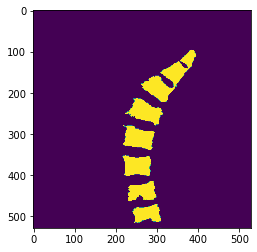

In [276]:
im = plt.imshow(roi_final_ind[22,10,:,:])

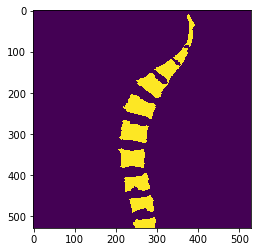

In [277]:
im = plt.imshow(mask_final_ind[22,10,:,:])

In [278]:
mresampfile = os.listdir(mresampath)
mresampfile.sort()
num_img = len(mresampfile)

num = 0

for n in os.listdir(mresampath):
    
    ind_test = mask_final_ind[num,10,:,:]
    ind_pred = roi_final_ind[num,10,:,:]
    dsc = dice_coef2(ind_test, ind_pred)
    iou = dsc/(2-dsc)
    print(num,dsc,iou)
    
    if num < num_img-1:
        num = num + 1

0 0.8874162534589854 0.7976174883175605
1 0.9531042105909565 0.9104098232441732
2 0.9520243913374883 0.9084413639669706
3 0.06325895772049611 0.032662579219182364
4 0.977017869631273 0.955068363979255
5 0.7105310433320675 0.5510260946243511
6 0.04697419610497986 0.02405200996899109
7 0.9808056756888089 0.9623343186802709
8 0.31988490514078455 0.19039463791472522
9 0.44877469085302274 0.28930335793696216
10 0.20260243398430497 0.1127198777916537
11 0.6236908880464576 0.4531619260742861
12 0.21305254155753917 0.11922708782005265
13 0.9613840720081835 0.9256396383859026
14 0.05166353756554472 0.026516743160978927
15 0.7175627320766425 0.5595304737506476
16 0.1837515950659294 0.10117096018735364
17 0.17648021163010083 0.09677998163533062
18 0.32412097484945435 0.19340356313627008
19 0.9181088700932553 0.848614841839394
20 0.6044980222313716 0.433176041210596
21 0.675139688766991 0.509593111849398
22 0.4846683843813286 0.31984311512133984
23 0.9003949582133207 0.818834876157284
24 0.4240884

In [15]:
model_json = model.to_json()
with open("model.json","w") as json_file :
    json_file.write(model_json)

In [17]:
from keras.models import model_from_json
json_file = open("model.json","r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('2d_unet_BM.h5')

In [18]:
loaded_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = [iou, iou_thresholded])

In [21]:
score = loaded_model.evaluate(y_test,y_pred,verbose=0)

In [22]:
score

[3.6646684852399325, 0.007991406145064455, 0.00671711629452674]